In [1]:
!pip install pydicom

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
import cv2
import pickle
import sklearn
import pydicom
import random

from sklearn.metrics import auc, f1_score, roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import metrics
from google.colab import files
from keras.preprocessing import image
from keras.layers.serialization import activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from tensorflow.keras import layers, Model
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
!pip install h5py pyyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00


##**Data Directory**

In [2]:
base_dir = '/content/drive/MyDrive/PETonlyWholeDataset'

training_set_dir = os.path.join(base_dir, 'trainingSet')
test_set_dir = os.path.join(base_dir, 'testSet')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer')
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

In [3]:
train_lungCancer_names = os.listdir(train_lungCancer_dir)
print(train_lungCancer_names[:10])

train_normal_names = os.listdir(train_normal_dir)
print(train_normal_names[:10])

['00000094 (18).dcm', '00000094 (5).dcm', '00000094 (8).dcm', '00000094 (1).dcm', '00000094 (9).dcm', '00000094 (16).dcm', '00000094 (2).dcm', '00000094 (3).dcm', '00000094 (14).dcm', '00000094 (10).dcm']
['00000001 (9).dcm', '00000001 (23).dcm', '00000001 (6).dcm', '00000001 (13).dcm', '00000001 (17).dcm', '00000001 (16).dcm', '00000001 (21).dcm', '00000001 (20).dcm', '00000001 (31).dcm', '00000001 (19).dcm']


In [5]:
print('total training lungCancer images:', len(os.listdir(train_lungCancer_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total test lungCancer images:', len(os.listdir(test_lungCancer_dir)))
print('total test lungCancer images:', len(os.listdir(test_lungCancer_dir)))

total training lungCancer images: 811
total training normal images: 809
total test lungCancer images: 205
total test lungCancer images: 205


##**Checking Patient Overlap**

In [6]:
def check_data_leakage(directory1, directory2):
    filenames_dir1 = set(os.listdir(directory1))
    filenames_dir2 = set(os.listdir(directory2))

    common_filenames = filenames_dir1.intersection(filenames_dir2)

    if len(common_filenames) > 0:
        print("Data leakage detected!")
        print("Common image filenames between the directories:", common_filenames)
    else:
        print("No data leakage detected.")

In [7]:
check_data_leakage(train_lungCancer_dir, test_lungCancer_dir)
check_data_leakage(train_normal_dir, test_normal_dir)
check_data_leakage(train_lungCancer_dir, test_normal_dir)
check_data_leakage(train_normal_dir, test_lungCancer_dir)

No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


##**Data Visualization**

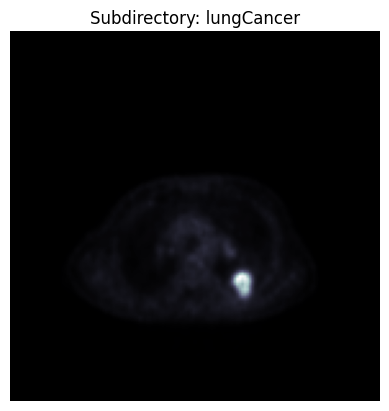

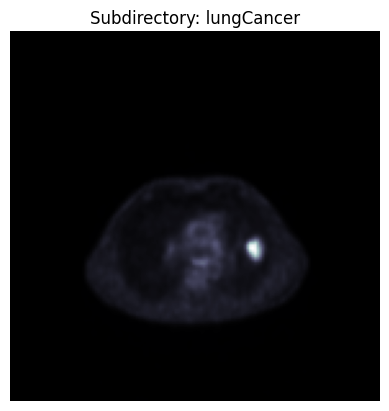

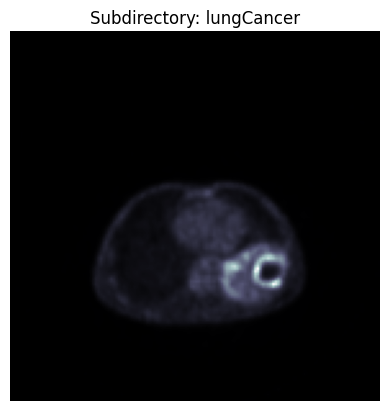

In [8]:
def display_random_dicom_images(directory, num_images=3):
    filenames = os.listdir(directory)
    random_images = random.sample(filenames, num_images)

    for filename in random_images:
        dicom_filepath = os.path.join(directory, filename)
        dicom_data = pydicom.dcmread(dicom_filepath)

        plt.imshow(dicom_data.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Subdirectory: {os.path.basename(directory)}")
        plt.axis('off')
        plt.show()

display_random_dicom_images(test_lungCancer_dir, num_images=3)

(114, 144)


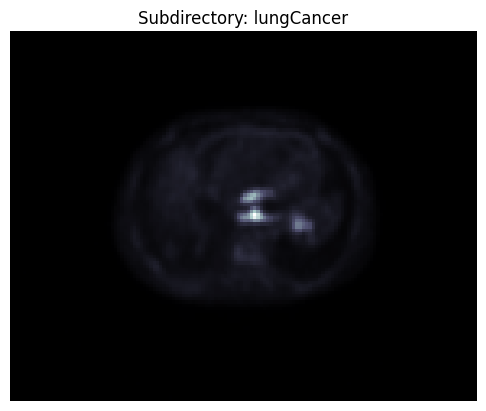

(114, 144)


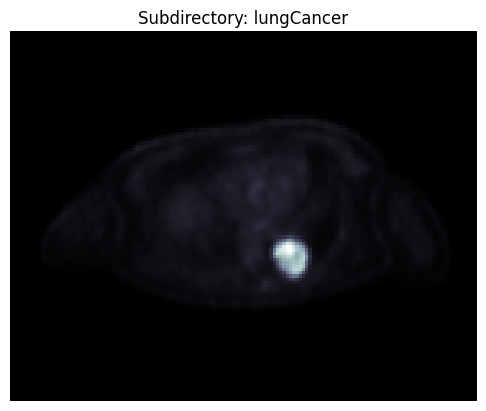

(114, 144)


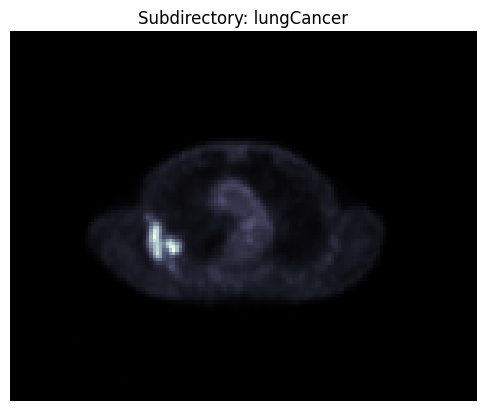

In [9]:
def display_random_dicom_images(directory, num_images=3):
    filenames = os.listdir(directory)
    random_images = random.sample(filenames, num_images)

    for filename in random_images:
        dicom_filepath = os.path.join(directory, filename)
        dicom_data = pydicom.dcmread(dicom_filepath)
        image = dicom_data.pixel_array
        cropped_image = image[30:, :]
        print(cropped_image.shape)

        plt.imshow(cropped_image, cmap=plt.cm.bone)
        plt.title(f"Subdirectory: {os.path.basename(directory)}")
        plt.axis('off')
        plt.show()

display_random_dicom_images(test_lungCancer_dir, num_images=3)

##Data loading

In [10]:
def load_and_preprocess_dicom(dcm_path, crop_start):
    dcm_data = pydicom.dcmread(dcm_path)
    image = dcm_data.pixel_array.astype(np.float32) / 255.0

    cropped_image = image[crop_start:, :]

    image_single_channel = np.expand_dims(cropped_image, axis=-1)

    image_rgb = np.concatenate([image_single_channel] * 3, axis=-1)

    resized_image = tf.image.resize(image_rgb, (114, 144))

    return resized_image

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')


train_images = np.array([load_and_preprocess_dicom(os.path.join(train_lungCancer_dir, filename), 30) for filename in os.listdir(train_lungCancer_dir) if filename.endswith('.dcm')])
train_labels = np.array([1] * len(train_images))

normal_train_images = np.array([load_and_preprocess_dicom(os.path.join(train_normal_dir, filename), 30) for filename in os.listdir(train_normal_dir) if filename.endswith('.dcm')])
normal_train_labels = np.array([0] * len(normal_train_images))

train_images = np.concatenate((train_images, normal_train_images))
train_labels = np.concatenate((train_labels, normal_train_labels))

train_generator = train_datagen.flow(train_images, train_labels, batch_size=40)

test_images = np.array([load_and_preprocess_dicom(os.path.join(test_lungCancer_dir, filename), 30) for filename in os.listdir(test_lungCancer_dir) if filename.endswith('.dcm')])
test_labels = np.array([1] * len(test_images))

normal_test_images = np.array([load_and_preprocess_dicom(os.path.join(test_normal_dir, filename), 30) for filename in os.listdir(test_normal_dir) if filename.endswith('.dcm')])
normal_test_labels = np.array([0] * len(normal_test_images))

test_images = np.concatenate((test_images, normal_test_images))
test_labels = np.concatenate((test_labels, normal_test_labels))

##**Model defining and compiling**

In [12]:
pre_trained_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=(114, 144, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

31790344/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 114, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 114, 144, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 114, 144, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

In [13]:
last_layer = pre_trained_model.get_layer('top_activation')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)


model = Model(pre_trained_model.input, x)

last layer output shape: (None, 4, 5, 1408)


In [14]:
savingPath = os.makedirs('/content/sample_data/temporaryWeights')
checkpoint_path = '/content/sample_data/temporaryWeights'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/sample_data/temporaryWeights


In [15]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                       tf.keras.metrics.Precision(name='Precision'),
                       tf.keras.metrics.Recall(name='Recall'),
                       tf.keras.metrics.TruePositives(name='TP'),
                       tf.keras.metrics.TrueNegatives(name='TN'),
                       tf.keras.metrics.FalseNegatives(name='FN'),
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.AUC(name='AUC')])

history = model.fit(train_generator,
                    validation_data=(test_images, test_labels),
                    epochs = 20,
                    verbose = 1,
                    callbacks = [cp_callback])

Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 1.9459 - Binary_accuracy: 0.5062 - Precision: 0.5069 - Recall: 0.4969 - TP: 403.0000 - TN: 417.0000 - FN: 408.0000 - FP: 392.0000 - AUC: 0.5041
Epoch 1: val_loss improved from inf to 0.73600, saving model to /content/sample_data/temporaryWeights
41/41 [==============================] - 55s 464ms/step - loss: 1.9459 - Binary_accuracy: 0.5062 - Precision: 0.5069 - Recall: 0.4969 - TP: 403.0000 - TN: 417.0000 - FN: 408.0000 - FP: 392.0000 - AUC: 0.5041 - val_loss: 0.7360 - val_Binary_accuracy: 0.4938 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 200.0000 - val_FN: 205.0000 - val_FP: 0.0000e+00 - val_AUC: 0.8176
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 0.8160 - Binary_accuracy: 0.5062 - Precision: 0.5071 - Recall: 0.4858 - TP: 394.0000 - TN: 426.0000 - FN: 417.0000 - FP: 383.0000 - AUC: 0.5172
Epoch 2: val_loss improved from 0.73600 to 0.69451, saving model t

##**History**

In [ ]:
def download_history():
  with open('history_augmented_59wholeModel.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented_59wholeModel.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Plotting Loss and Accuracy**

In [ ]:
plt.plot(history.history['Binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_Binary_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss and Test Loss')
plt.show()

##**Confusion matrix**

In [ ]:
cm = confusion_matrix(test_labels, model.predict(test_images) > 0.5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Lung Cancer'], yticklabels=['Normal', 'Lung Cancer'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##**ROC curve**

In [ ]:
y_pred_prob = model.predict(test_images)

y_pred_prob = y_pred_prob.ravel()

threshold = 0.5
y_pred = np.where(y_pred_prob >= threshold, 1, 0)

fpr, tpr, _ = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()